# 5. Generalized edge conditions

In the previous part, we demonstrated the means of annihilating the (nearly) singular behavior at edges on a discretized surface. In some cases, our desire is not to annihilate this behavior, but simply to keep it within some bounds. In the analytical treatment of potential flow problems, this objective is served by placing an inequality constraint on the edge suction parameter. That parameter is proportional to the coefficient on the bound vortex sheet strength's singularity, so in this discrete setting, in which we have extracted the singular part of $\mathfrak{f}$ in the form of $\mathfrak{f}_0$, we expect the suction parameter to be related to the value of $\tilde{\mathfrak{f}}$ at the edge. In fact, by simple comparison, it can be shown that

$\mathfrak{e}_{k}^T\tilde{\mathfrak{f}} = -\frac{2\pi c}{\Gamma_0} \sigma_{k}$

for a flat plate of length $c$, where $\sigma_{k}$ is the suction parameter at the edge corresponding to point $k$.

Let $\sigma_{k}^{\mathrm{min}}$ and $\sigma_{k}^{\mathrm{max}}$ denote the minimum and maximum tolerable values of $\sigma_{k}$ at edge $k$. We then seek to confine the suction parameter to the range $\sigma_{k}^{\mathrm{min}} \leq \sigma_{k} \leq \sigma_{k}^{\mathrm{max}}$. This generalized edge constraint is placed on the suction parameter of the intermediate sheet $\tilde{\mathfrak{f}}^*$. To avoid confusion, we will redefine the bounds based on this smooth part of the vortex sheet rather than $\sigma_{k}$ itself; for this, we define $f^{\mathrm{min}}_{k} = -\frac{2\pi c}{\Gamma_0} \sigma_{k}^{\mathrm{max}}$ and $f^{\mathrm{max}}_{k} = -\frac{2\pi c}{\Gamma_0} \sigma_{k}^{\mathrm{min}}$ if $\Gamma_0$ is positive or $f^{\mathrm{max}}_{k} = -\frac{2\pi c}{\Gamma_0} \sigma_{k}^{\mathrm{max}}$ and $f^{\mathrm{min}}_{k} = -\frac{2\pi c}{\Gamma_0} \sigma_{k}^{\mathrm{min}}$ if $\Gamma_0$ is negative. Thus, we inspect whether the value $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}}^*$ lies in the range

$f^{\mathrm{min}}_{k} \leq \mathfrak{e}_{k}^T\tilde{\mathfrak{f}}^* \leq f^{\mathrm{max}}_{k}.$

If $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}}^*$ lies within this range, then no new vortex is created near the edge (or equivalently, a new vortex of zero strength is created); if $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}}^* > f^{\mathrm{max}}_{k}$, then we create a new vortex so that $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}} = f^{\mathrm{max}}_{k}$; and if $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}}^* < f^{\mathrm{min}}_{k}$, then we do the same, but now so that $\mathfrak{e}_{k}^T\tilde{\mathfrak{f}} = f^{\mathrm{min}}_{k}$. Note that the Kutta condition simply corresponds to setting $f^{\mathrm{min}}_{k} = f^{\mathrm{max}}_{k} = 0$.

Let's illustrate this again with the example of a flat plate. To clearly show the effect of varying the suction parameter, we will run a simulation of the vortex shedding for a couple of time steps for three different suction parameter ranges. First we create the grid and the flate plate.

In [1]:
using GridPotentialFlow
using Plots
Δx = 0.01
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);
c = Lx/2 # chord length
α = -π/3 # angle of attack
plate = Plate(c,4*cellsize(g));
Tr = RigidTransform((0.0,0.0),α)
Tr(plate)
Δs = dlengthmid(plate);

We create three instances of `PotentialFlowBody`, each one with a different suction parameter range. We only vary the suction parameter at the leading edge and keep it at zero (Kutta condition) at the trailing edge.

In [2]:
σLE_list = [0.0,0.05,0.1];
pfb_list = [PotentialFlowBody(plate,edges=[1,length(plate)],σ=[SuctionParameter(σLE),SuctionParameter(0.0)]) for σLE in σLE_list];

The initial point vortices are the same in each case.

In [3]:
Δt = 2e-2
vLE = Vortex(plate.x[1]+3Δt*plate.len*cos(plate.α+π/2),plate.y[1]+3Δt*plate.len*sin(plate.α+π/2),0.0);
vTE = Vortex(plate.x[end]+3Δt*cos(α+π/2),plate.y[end]+3Δt*sin(α+π/2),0.0);

At each time step, we will need to insert new point vortices near the regularized edges to simulate the vortex shedding. A good strategy is to place them one-third of the way from the edge to the last released vortex from that edge. This will happen at each time step, so we create a function for it.

In [4]:
function createsheddedvortices(plate,oldvortices)

    vLE = Vortex(2/3*plate.x[1]+1/3*oldvortices[end-1].x,2/3*plate.y[1]+1/3*oldvortices[end-1].y,0.0)
    vTE = Vortex(2/3*plate.x[end]+1/3*oldvortices[end].x,2/3*plate.y[end]+1/3*oldvortices[end].y,0.0)

    return vLE, vTE
end

createsheddedvortices (generic function with 1 method)

We create a vortex models with the initial point vortices.

In [5]:
model_list = [VortexModel(g,bodies=[pfb],vortices=[vLE,vTE],U∞=(1.0,0.0)) for pfb in pfb_list];

Now we can advance the solution in time.

In [6]:
T = 0:Δt:0.2
for t in T
    for vm in model_list
        X = getvortexpositions(vm)
        Ẋ = vortexvelocities!(vm)
        X .= X .+ Ẋ*Δt
        setvortexpositions!(vm, X)
        vLEnew, vTEnew = createsheddedvortices(plate,vm.vortices[end-1:end])
        pushvortices!(vm,vLEnew,vTEnew)
    end
end

By plotting the positions of the point vortices emanating from the leading edge, we see that as $\sigma_{k}^{\mathrm{max}}$ increases, the stream of point vortices is swept back from the edge.

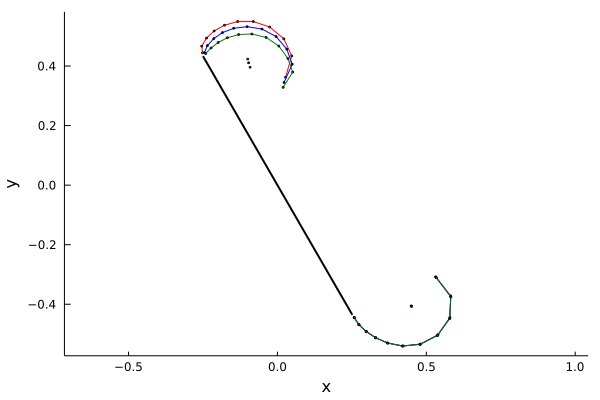

In [7]:
colors = [:red,:blue,:green];
plot(plate,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")
for i in 1:length(model_list)
    plot!(model_list[i].vortices.x[4:2:end],model_list[i].vortices.y[4:2:end],color=colors[i],marker=:circle,markersize=2)
    plot!(model_list[i].vortices.x[3:2:end],model_list[i].vortices.y[3:2:end],color=colors[i],marker=:circle,markersize=2)
    scatter!(model_list[i].vortices.x[1:2],model_list[i].vortices.y[1:2],color=colors[i],marker=:circle,markersize=2,label="σLE=$(σLE_list[i])")
end
plot!()

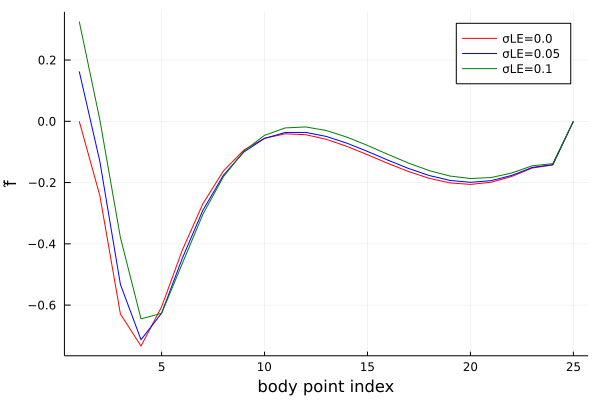

In [8]:
plot(xlabel="body point index",ylabel="f̃")
for i in 1:length(model_list)
    sol = solve(model_list[i]);
    plot!(sol.f./model_list[i].system.f₀,linecolor=colors[i],label="σLE=$(σLE_list[i])")
end
plot!()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*